# Installing Keras

To proceed with this tutorial, make sure you have a working installation of tensorflow and Keras in your machine. 

In [ ]:
!conda install keras

If that doesn't work, check out https://keras.io/#installation for details on proper installation.
___

# Introduction to convnets using Keras

First, let's import the Keras deep learning library that provides us with a convenient interface to TensorFlow.

In [6]:
import keras
keras.__version__

'2.2.4'

Let's take a practical look at a very simple convnet example. We will use our convnet to classify MNIST digits, a task that you've already done in previous Practicals, using logistic regression and a densely-connected neural network. Even though our convnet will be very basic, its accuracy will still blow out of the water that of the densely-connected model from the TensorFlow practical.

![](./images/mnist.png)

Our workflow will be as follow: first we will present our neural network with the `training data`, `train_images` and `train_labels`. The network will then learn to associate images and labels. Finally, we will ask the network to produce predictions for `test_images`, and we will verify if these predictions match the labels from `test_labels`.

Let's build our network.

The 6 lines of code below show you what a basic convnet looks like in Keras. It's a stack of `Conv2D` and `MaxPooling2D` layers. Importantly, a convnet takes as input tensors of shape `(image_height, image_width, image_channels)` (not including the batch dimension containing the different samples in the data set). In our case, we will configure our convnet to process inputs of size `(28, 28, 1)`, which is the format of MNIST images. We do this via passing the argument `input_shape=(28, 28, 1)` to our first layer.

In [7]:
from keras import layers
from keras import models

model = models.Sequential()

#The next layer is design to have 32 channels (kernesl) in depth of size 3x3.
#The activation function is said to be A rectifier Linear unit (Relu)
#The input to the layer are 28 x 28 grayscale images
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))) 
#now we add a Max pooling layer of size 2x2
model.add(layers.MaxPooling2D((2, 2)))
#Another convolutional layer, this one with 64 kernels
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#and another Max pooling
model.add(layers.MaxPooling2D((2, 2)))
#And another convolution
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of our convnet so far:

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


You can see above that the output of every `Conv2D` and `MaxPooling2D` layer is a 3D tensor of shape `(height, width, channels)`. The width 
and height dimensions tend to shrink as we go deeper in the network. The number of channels is controlled by the first argument passed to 
the `Conv2D` layers (e.g. 32 or 64).

The next step would be to feed our last output tensor (of shape `(3, 3, 64)`) into a densely-connected classifier network like those you are already familiar with: a stack of `Dense` layers. These classifiers process vectors, which are 1D, whereas our current output is a 3D tensor. So first, we will have to flatten our 3D outputs to 1D, and then add a few `Dense` layers on top:

In [9]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We are going to do 10-class classification (digits 0-9), so we use a final layer with 10 outputs and a softmax activation. Now here's what our network looks like:

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

As you can see, our `(3, 3, 64)` outputs were flattened into vectors of shape `(576,)`, before going through two `Dense` layers.

Notice that this very simple network has more than 93,000 parameters (weights) to be tuned during training.

Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in the [0, 1] interval. Previously, our training images for instance were stored in flat arrays of shape (60000, 28* 28) of type uint8 with values in the [0, 255] interval. We transform it into a float32 array of shape (60000, 28, 28) with values between 0 and 1. Hence, notice that with convolutional networks we can exploit the 2 dimensional structure contained in images and therefore we should avoid flattening the input images.

We also need to divide the entire data set into a training and testing set.

In [11]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Let's normalize the input data:

In [12]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

Let's take a look at the first 10 labels in the training set:

In [13]:
train_labels[0:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

This vector of target values indicates that the first image in the training set is a 5, the second is a 0, the third is a 4, etc.

We need to categorically encode the labels. To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot" encoding. One-hot encoding is a widely used format for categorical data, also called "categorical encoding". Note that there is a built-in way to do this in Keras:

In [14]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
train_labels[0:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

This is a one-hot encoding of our labels, again indicating that the first image in the training set is a 5, the second is a 0, the third is a 4, etc.

To make our network ready for training, we need to pick three more things, as part of a "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be 
able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function (`rmsprop` is a variation of the gradient descent algorithm we are used to). 
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly 
classified).


In [15]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Now, let's train our convnet on the MNIST digits. 

In [16]:
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
60000/60000 [==============================] - 24s 399us/step - loss: 0.1669 - acc: 0.9473
Epoch 2/5
60000/60000 [==============================] - 23s 382us/step - loss: 0.0486 - acc: 0.9847
Epoch 3/5
60000/60000 [==============================] - 23s 387us/step - loss: 0.0333 - acc: 0.9895
Epoch 4/5
60000/60000 [==============================] - 23s 387us/step - loss: 0.0267 - acc: 0.9921
Epoch 5/5
60000/60000 [==============================] - 23s 385us/step - loss: 0.0197 - acc: 0.9940


Let's evaluate the model on the test data:

In [17]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 138us/step


In [18]:
test_acc

0.9925

Our densely-connected network using TensorFlow had a test accuracy of 97%, our basic convolutional network has a test accuracy above  99%: we decreased our error rate by more than 60% (relative). Not bad! I hope this demonstration illustrates that convolutional networks are the proper way to go for machine vision problems.

### Graph of your model
plot_model(): plots your graph in a nice layout. You can even save it as ".png" using SVG(). 

In [19]:
from keras.utils import plot_model
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plot_model(model,to_file='myFirstConvolutionalNeuralNetworkModel.png')

You can also directly obtain the `pydot.Graph` object and render it yourself, for example to show it in an ipython notebook :

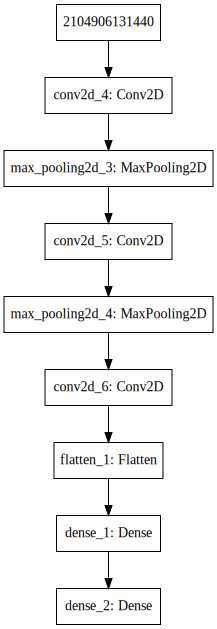

In [21]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))